In [1]:
using Statistics, Distributions

In [2]:
using Plots, Random

In [3]:
using CSV, DataFrames
df = CSV.File("df_kde.csv") |> DataFrame
size(df)

(180, 4)

In [4]:
Econvalue = df[:, :EconValue]
Harmvalue = df[:, :HarmValue]
Variability = df[:, :Variability]

size(Econvalue), size(Harmvalue), size(Variability)
typeof(Econvalue), typeof(Harmvalue), typeof(Variability)

(Vector{Float64}, Vector{Float64}, Vector{Float64})

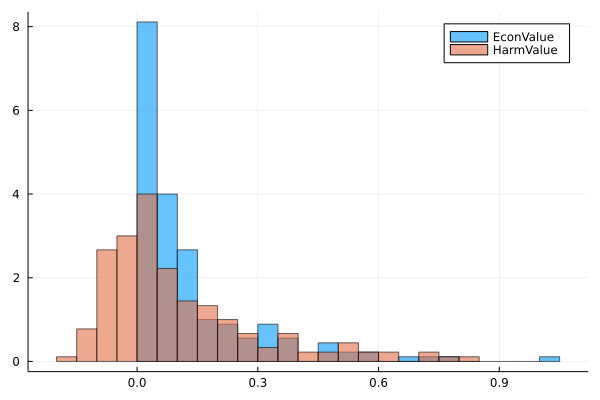

In [5]:
histogram(Econvalue./(maximum(Econvalue)-minimum(Econvalue)), alpha=0.6, normed=true, bins=30, label="EconValue")
histogram!(Harmvalue./(maximum(Harmvalue)-minimum(Harmvalue)), alpha=0.6, normed=true, bins=30, label="HarmValue")

In [200]:
maximum(Econvalue), minimum(Econvalue)

(0.139671215, 0.00048215)

In [201]:
maximum(Harmvalue), minimum(Harmvalue)

(7.03045974728524, -1.2722232855296498)

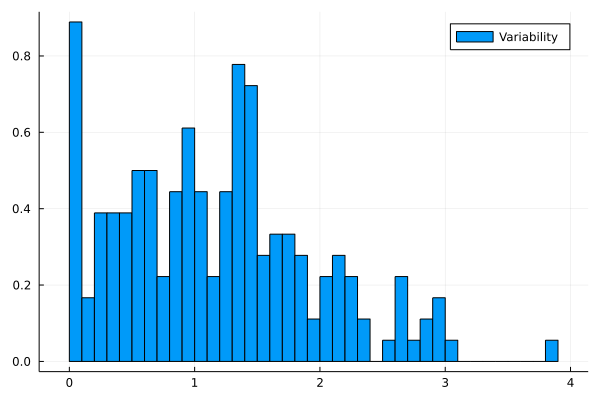

In [202]:
histogram(Variability, bins=50, label="Variability", normed=true)

In [6]:
# Select on Variability
observations = []
rest = []
threshold = median(Variability)
for i in 1:length(Variability)
    if Variability[i] <= threshold
        push!(observations, (Econvalue[i], Harmvalue[i]))
    else
        push!(rest, (Econvalue[i], Harmvalue[i]))
    end
end
length(observations)

90

In [7]:
# KDE
using StatsBase, LinearAlgebra, Roots, Optim

xs = 0:1/2^8:0.15
ys = -1.5:15/2^6:7.5
n = length(observations)

D(u) = abs(u) < 1 ? 70/81*(1-abs(u)^3)^3 : 0
D(λ,u) = 1/λ*D(u/λ)
K(λ,x,y) = D(λ,x) * D(λ,y) # Kernel function
kde(λ,x,y,observations) = sum(K(λ,x-Xi,y-Yi) for (Xi,Yi) in observations)/length(observations)

function kdeCV(λ,i,observations)
  x,y = observations[i] 
  newobservations = copy(observations)
  deleteat!(newobservations,i)  # one left out
  kde(λ,x,y,newobservations) # estimate the joint distribution with one left-out
end

kdeCV (generic function with 1 method)

In [8]:
# ∫f̂^2 - 2∫f̂⋅f = ∫f̂^2 - 2∑f⋅f̂
# use cross-validation value for the second part
J(λ) = sum([kde(λ,x,y,observations)^2 for x=xs,y=ys])*step(xs)*step(ys) -
        2/n*sum(kdeCV(λ,i,observations) for i=1:n)
λ_best_cv = optimize(λ->J(first(λ)),[1.0],BFGS())

 * Status: success

 * Candidate solution
    Final objective value:     -2.325453e+00

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.36e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.31e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.06e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.18e-14 ≰ 0.0e+00
    |g(x)|                 = 7.33e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    5
    f(x) calls:    31
    ∇f(x) calls:   31


In [10]:
λ = first(λ_best_cv.minimizer) # Nadaraya-Watson
r̂(λ, x) = sum(D(λ,x-Xi)*Yi for (Xi,Yi) in observations)/sum(D(λ,x-Xi) for (Xi,Yi) in observations)

r̂ (generic function with 1 method)

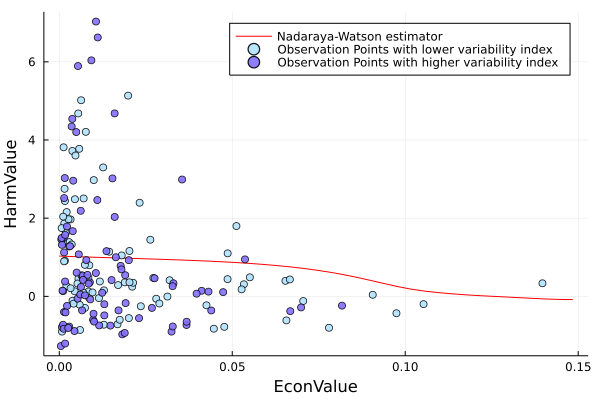

In [11]:
plot(xs, x->r̂(λ,x), label = "Nadaraya-Watson estimator", color = :Red)
     #ylims = (0,10))
scatter!(Tuple.(observations), label="Observation Points with lower variability index",
    color=:lightskyblue1,alpha=0.9,markersize=4)
scatter!(Tuple.(rest), label="Observation Points with higher variability index", 
    color=:slateblue1,alpha=0.9,xlabel="EconValue",ylabel="HarmValue",markersize=4)
# colors: http://juliagraphics.github.io/Colors.jl/stable/namedcolors/

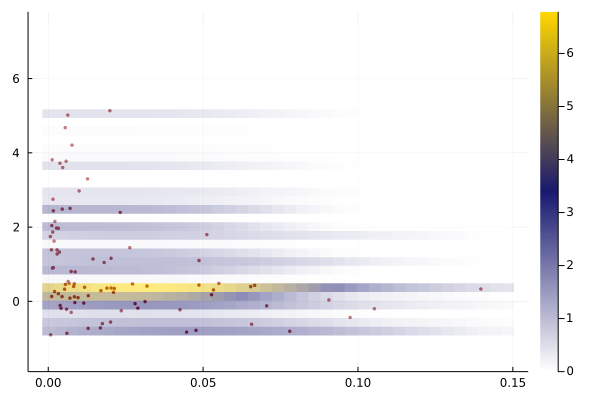

In [12]:
scatter(Tuple.(observations), markerstrokewidth=0, markersize=2, label = "",
            color = :DarkRed)
heatmap!(xs, ys, (x,y) -> kde(λ, x, y, observations), 
             opacity = 0.5, color = cgrad([:white, :MidnightBlue, :Gold]))

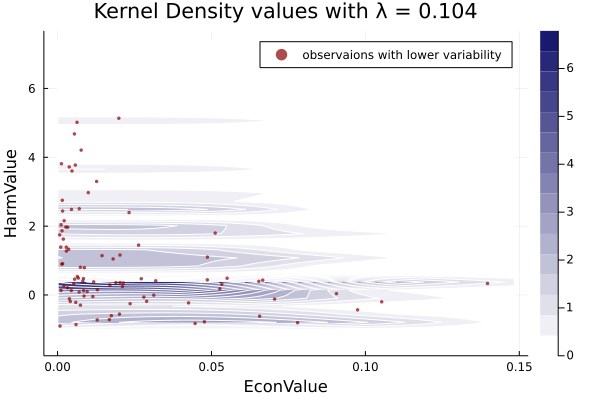

In [227]:
contourf(xs, ys, (x,y) -> kde(λ, x, y, observations), xlabel="EconValue",ylabel="HarmValue",
    color = cgrad(["white", "MidnightBlue"]), title="Kernel Density values with λ = 0.104")
scatter!(Tuple.(observations), markerstrokewidth=0, markersize=2, label = "observaions with lower variability",
            color = :DarkRed, alpha=0.7)
#plot!([(0, 0), (1, slope_of_best_line)], label = "best fit line", linewidth = 4, arrow = true)
#plot!([(0, 0), (1, slope_of_major_axis)], label = "major axis", linewidth = 4, arrow = true)

In [17]:
plotlyjs()
surface(xs, ys, (x,y) -> kde(λ, x, y, observations),c =:viridis, 
    xlabel="EconValue",ylabel="HarmValue", title="Approximated Joint Distribution by KDE")

In [278]:
plotlyjs()
surface(xs, ys, (x,y) -> kde(λ, x, y, observations))

In [16]:
plotlyjs()
surface(-0.15:0.001:0.15, -0.15:0.001:0.15, (x, y)->K(λ, x, y),c=:viridis, title="Kernel function K(λ, x, y) with λ = 0.104"
)